# Généralisation robuste de LDA/QDA

Andrew Wang

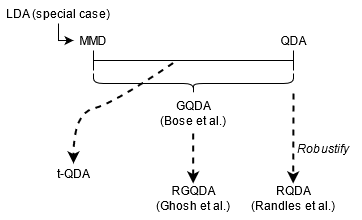

Méthodes classiques: MMD, (LDA,) QDA  
Méthodes génerales: GQDA (qui généralise le regle de classification pour les distributions ES avec la variable c qui interpole entre 0 (MMD) et 1 (QDA))  
Méthodes robustes: RQDA (utilisant le regle QDA mais avec estimation robuste - on peut compter M-estimator, MVE, MCD, S-estimator optimal(selon Croux et al.), etc  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RGQDA  
Cas particulier: t-QDA (la variable c calculée en termes de DOFs, estimation robuste avec EM)  

QDA avec ES: estimation des parametres avec le meme EM (mais avec E-step fixé) et calculation des posteriors avec le E-step

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:

from plotnine import *
from plotnine.data import *


# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis
from scipy import stats, special, optimize
from sklearn.model_selection import train_test_split
# EMBEDDINGs:
import umap
warnings.filterwarnings('ignore') # AMI warning

In [247]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from import_subset_datasets import *
from clustering_accuracy import acc
from vis import *
from dataset_utils import *
from models import *

In [4]:
%run models

In [5]:
def run_all(X, y, X_test, y_test, slow=True):
    print("LDA")
    ldatest = LDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
    ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), ldatest.predict(X_test))
    print("QDA")
    qdatest = QDA(method='generalised')#discriminant_analysis.QuadraticDiscriminantAnalysis()
    qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qdatest.predict(X_test))
    print("t-LDA")
    t_ldatest = t_LDA(method='distributional')
    t_ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_ldatest.predict(X_test))
    print("t-QDA")
    t_qdatest = t_QDA(method='distributional')
    t_qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_qdatest.predict(X_test))
    if not slow:
        return ldatest, qdatest, t_ldatest, t_qdatest
    print("GQDA")
    gqdatest = GQDA()
    gqdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), gqdatest.predict(X_test))
    print("RGQDA")
    rgqdatest = RGQDA('M-estimator')
    rgqdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdatest.predict(X_test))
    print("RGQDA-S")
    rgqdastest = RGQDA('S-estimator')
    rgqdastest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdastest.predict(X_test))
    print("RQDA-M")
    rqdatest = RGQDA('M-estimator')
    rqdatest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdatest.predict(X_test))
    print("RQDA-S")
    rqdastest = RGQDA('S-estimator')
    rqdastest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdastest.predict(X_test))
    return ldatest, qdatest, t_ldatest, t_qdatest, gqdatest, rgqdatest, rgqdastest, rqdatest, rqdastest

## Fashion-MNIST

### Prepare MNIST data

In [6]:
np.random.seed(44)
random.seed(44)

#read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
#read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

read_mnist_train = pd.read_csv(r"data\fashion-mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\fashion-mnist_test.csv")

In [7]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [0,2,3,4,6]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
#mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [8]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [9]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

In [10]:
ret =  lda_grid(em, mapper)
%store ret

Stored 'ret' (tuple)


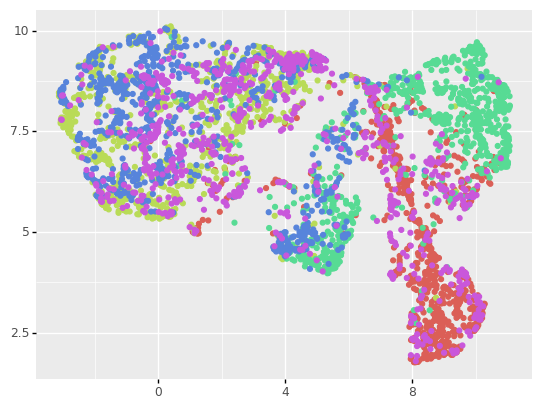

<ggplot: (178743245273)>

In [11]:
gg

### Pure MNIST test

In [12]:
models_MNIST_pure = run_all(mnist_pca, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
Accuracy 0.723 ARI 0.45374 AMI 0.46753
QDA
Accuracy 0.734 ARI 0.48004 AMI 0.48223
t-LDA
Accuracy 0.7145 ARI 0.43086 AMI 0.45132
t-QDA
Accuracy 0.7365 ARI 0.47754 AMI 0.48499
GQDA
optimal c is 0.49860251442480774
Accuracy 0.7465 ARI 0.49395 AMI 0.49339
RGQDA
optimal c is 0.8311971646188815
Accuracy 0.7295 ARI 0.46373 AMI 0.4717
RGQDA-S
optimal c is 0.43589705544124036
Accuracy 0.7125 ARI 0.4273 AMI 0.44851
RQDA-M
Accuracy 0.725 ARI 0.45994 AMI 0.46928
RQDA-S
Accuracy 0.7105 ARI 0.43114 AMI 0.44914


### MNIST with mislabelling test

In [13]:
mnist_labels_mislabelled = mislabelled(800, 0.1, np.unique(mnist_labels))

In [14]:
models_MNIST_contaminated_mislabelled = run_all(mnist_pca, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

LDA
Accuracy 0.726 ARI 0.45696 AMI 0.46784
QDA
Accuracy 0.7365 ARI 0.48316 AMI 0.48081
t-LDA
Accuracy 0.7205 ARI 0.43993 AMI 0.45616
t-QDA
Accuracy 0.737 ARI 0.47981 AMI 0.48494
GQDA
optimal c is 0.04249253866083121
Accuracy 0.759 ARI 0.51498 AMI 0.51059
RGQDA
optimal c is 0.8172921608024983
Accuracy 0.734 ARI 0.47549 AMI 0.47875
RGQDA-S
optimal c is 0.045728417957797245
Accuracy 0.7275 ARI 0.45205 AMI 0.46892
RQDA-M
Accuracy 0.729 ARI 0.46779 AMI 0.47263
RQDA-S
Accuracy 0.7135 ARI 0.43875 AMI 0.45482


### MNIST with contamination test

In [15]:
mnist_pca_contaminated = contaminate_dataset(mnist_pca, 0.1)

In [16]:
models_MNIST_contaminated_mislabelled = run_all(mnist_pca_contaminated, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
Accuracy 0.679 ARI 0.35995 AMI 0.41297
QDA
Accuracy 0.5475 ARI 0.25107 AMI 0.32272
t-LDA
Accuracy 0.7135 ARI 0.42933 AMI 0.4501
t-QDA
Accuracy 0.735 ARI 0.47195 AMI 0.47714
GQDA
optimal c is 0.0
Accuracy 0.7055 ARI 0.43499 AMI 0.45737
RGQDA
optimal c is 0.9431248011733314
Accuracy 0.731 ARI 0.46661 AMI 0.47096
RGQDA-S
optimal c is 0.9427676743072988
Accuracy 0.7085 ARI 0.43309 AMI 0.45164
RQDA-M
Accuracy 0.728 ARI 0.46374 AMI 0.46849
RQDA-S
Accuracy 0.7065 ARI 0.43071 AMI 0.4499


### MNIST with contamination and mislabelling test

In [17]:
models_MNIST_contaminated_mislabelled = run_all(mnist_pca_contaminated, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

LDA
Accuracy 0.6785 ARI 0.36157 AMI 0.41229
QDA
Accuracy 0.52 ARI 0.214 AMI 0.30436
t-LDA
Accuracy 0.714 ARI 0.42915 AMI 0.44678
t-QDA
Accuracy 0.737 ARI 0.47826 AMI 0.48251
GQDA
optimal c is 0.018677592764096917
Accuracy 0.711 ARI 0.44229 AMI 0.44734
RGQDA
optimal c is 0.976626633477326
Accuracy 0.733 ARI 0.47314 AMI 0.47348
RGQDA-S
optimal c is 0.22986771733631195
Accuracy 0.7345 ARI 0.47056 AMI 0.48069
RQDA-M
Accuracy 0.734 ARI 0.47443 AMI 0.47427
RQDA-S
Accuracy 0.7145 ARI 0.44554 AMI 0.45986


## Sklearn discriminant analysis

### Sklearn LDA

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), lda.predict(mnist_test_pca))

In [ ]:
plot_contours_UMAP(gg, lda, *ret)

In [ ]:
plot_regions_UMAP(gg, lda, *ret)

### Sklearn QDA

In [ ]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), qda.predict(mnist_test_pca))

## Synthetic Data

In [18]:
np.random.seed(seed=233423)

In [19]:
def synthesise(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([1, 1, 1, 1, 1, 1 ]), shape=np.eye(6), df=1, hard=hard) #cauchy
    X2 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-1,-1,-1, 1, 1, 1]), shape=np.eye(6), df=3, hard=hard) #t
    X3 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([1, 1, 1, -1,-1,-1]), shape=np.eye(6), df=20, hard=hard) #normal
    X4 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-1,-1,-1,-1,-1,-1]), shape=np.eye(6), df=1, hard=hard) #cauchy
    
    return np.vstack([X1, X2, X3, X4]), mislabelled(n, mislabelling, np.arange(4))

In [20]:
X_test,y_test = synthesise(1000)

### Synthetic data pure

In [21]:
X,y = synthesise(1000, contamination=0, mislabelling=0)

In [22]:
models_synth_pure = run_all(X,y,X_test,y_test)

LDA
Accuracy 0.6475 ARI 0.31567 AMI 0.33083
QDA
Accuracy 0.54575 ARI 0.28166 AMI 0.32733
t-LDA
Accuracy 0.82925 ARI 0.60597 AMI 0.56268
t-QDA
Accuracy 0.82775 ARI 0.60295 AMI 0.55957
GQDA
optimal c is 0.15266192790876065
Accuracy 0.54225 ARI 0.20998 AMI 0.29091
RGQDA
optimal c is 0.9321341281019225
Accuracy 0.80425 ARI 0.5515 AMI 0.52357
RGQDA-S
optimal c is 0.8550457061780787
Accuracy 0.80125 ARI 0.54523 AMI 0.51946
RQDA-M
Accuracy 0.8065 ARI 0.55693 AMI 0.52681
RQDA-S
Accuracy 0.80475 ARI 0.55596 AMI 0.52393


### Synthetic data with mislabelling

In [23]:
X,y = synthesise(1000, contamination=0, mislabelling=0.1)

In [24]:
models_synth_mislabelling = run_all(X,y,X_test,y_test)

LDA
Accuracy 0.639 ARI 0.32666 AMI 0.34112
QDA
Accuracy 0.517 ARI 0.23048 AMI 0.26766
t-LDA
Accuracy 0.82325 ARI 0.59379 AMI 0.54823
t-QDA
Accuracy 0.8235 ARI 0.59466 AMI 0.54999
GQDA
optimal c is 0.07626267542615921
Accuracy 0.50975 ARI 0.1585 AMI 0.25252
RGQDA
optimal c is 0.7525114128443618
Accuracy 0.79475 ARI 0.53175 AMI 0.51225
RGQDA-S
optimal c is 0.8524555908272423
Accuracy 0.79825 ARI 0.54233 AMI 0.52097
RQDA-M
Accuracy 0.7985 ARI 0.54489 AMI 0.51387
RQDA-S
Accuracy 0.794 ARI 0.53855 AMI 0.51172


### Synthetic data with contamination

In [25]:
X,y = synthesise(1000, contamination=0.1, mislabelling=0)

In [26]:
models_synth_contamination = run_all(X,y,X_test,y_test)

LDA
Accuracy 0.6935 ARI 0.36604 AMI 0.36414
QDA
Accuracy 0.39925 ARI 0.09853 AMI 0.13587
t-LDA
Accuracy 0.819 ARI 0.5848 AMI 0.53967
t-QDA
Accuracy 0.8145 ARI 0.57644 AMI 0.5327
GQDA
optimal c is 0.13202836332401566
Accuracy 0.46925 ARI 0.12405 AMI 0.1987
RGQDA
optimal c is 0.9318450944490579
Accuracy 0.77925 ARI 0.50693 AMI 0.4759
RGQDA-S
optimal c is 0.9360152703667722
Accuracy 0.791 ARI 0.53338 AMI 0.49575
RQDA-M
Accuracy 0.77425 ARI 0.49876 AMI 0.46605
RQDA-S
Accuracy 0.7855 ARI 0.52516 AMI 0.48814


### Synthetic data with contamination and mislabelling

In [27]:
X,y = synthesise(1000, contamination=0.1, mislabelling=0.1)

In [28]:
models_synth_contamination_mislabelling = run_all(X,y,X_test,y_test)

LDA
Accuracy 0.72325 ARI 0.41421 AMI 0.40083
QDA
Accuracy 0.34525 ARI 0.03279 AMI 0.09596
t-LDA
Accuracy 0.823 ARI 0.59172 AMI 0.54563
t-QDA
Accuracy 0.8175 ARI 0.58205 AMI 0.53804
GQDA
optimal c is 0.03261438052426972
Accuracy 0.483 ARI 0.0904 AMI 0.20972
RGQDA
optimal c is 0.9622727948273809
Accuracy 0.763 ARI 0.48135 AMI 0.45319
RGQDA-S
optimal c is 0.9839520517375782
Accuracy 0.773 ARI 0.50502 AMI 0.47313
RQDA-M
Accuracy 0.75825 ARI 0.47324 AMI 0.44575
RQDA-S
Accuracy 0.771 ARI 0.50162 AMI 0.47037


## Synthetic data for visualisation

In [71]:
def synthesise2d(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([2 , 2]), shape=np.eye(2), df=1, hard=hard) #cauchy
    X2 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-2, 2]), shape=np.eye(2), df=3, hard=hard) #t
    X3 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([2 ,-2]), shape=np.eye(2), df=20, hard=hard) #normal
    X4 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-2,-2]), shape=np.eye(2), df=1, hard=hard) #cauchy
    X5 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([2 , 6]), shape=np.eye(2), df=1, hard=hard) #cauchy
    
    return np.vstack([X1, X2, X3, X4, X5]), mislabelled(n, mislabelling, np.arange(5))

In [346]:
X_test_2d,y_test_2d = synthesise2d(100)

In [347]:
X_2d,y_2d = synthesise2d(100, contamination=0.1, mislabelling=0.1)

In [348]:
models_vis = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
Accuracy 0.486 ARI 0.30332 AMI 0.36571
QDA
Accuracy 0.338 ARI 0.08205 AMI 0.17098
t-LDA
Accuracy 0.8 ARI 0.57381 AMI 0.55894
t-QDA
Accuracy 0.788 ARI 0.55568 AMI 0.54751
GQDA
optimal c is 0.05096689169987479
Accuracy 0.584 ARI 0.35102 AMI 0.42293
RGQDA
optimal c is 0.0
Accuracy 0.762 ARI 0.5147 AMI 0.52883
RGQDA-S
optimal c is 0.0
Accuracy 0.782 ARI 0.55481 AMI 0.55953
RQDA-M
Accuracy 0.784 ARI 0.56342 AMI 0.56193
RQDA-S
Accuracy 0.798 ARI 0.57942 AMI 0.56203


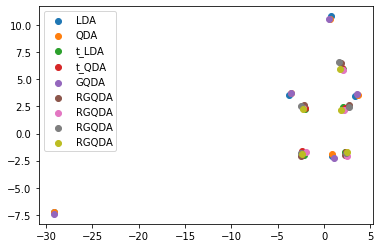

In [349]:
plot_means(models_vis)

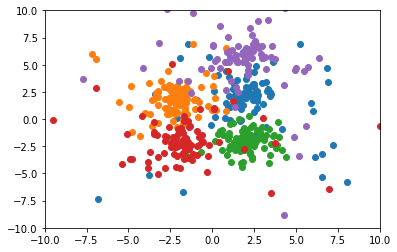

In [350]:
ax = plt.figure().gca()
plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)

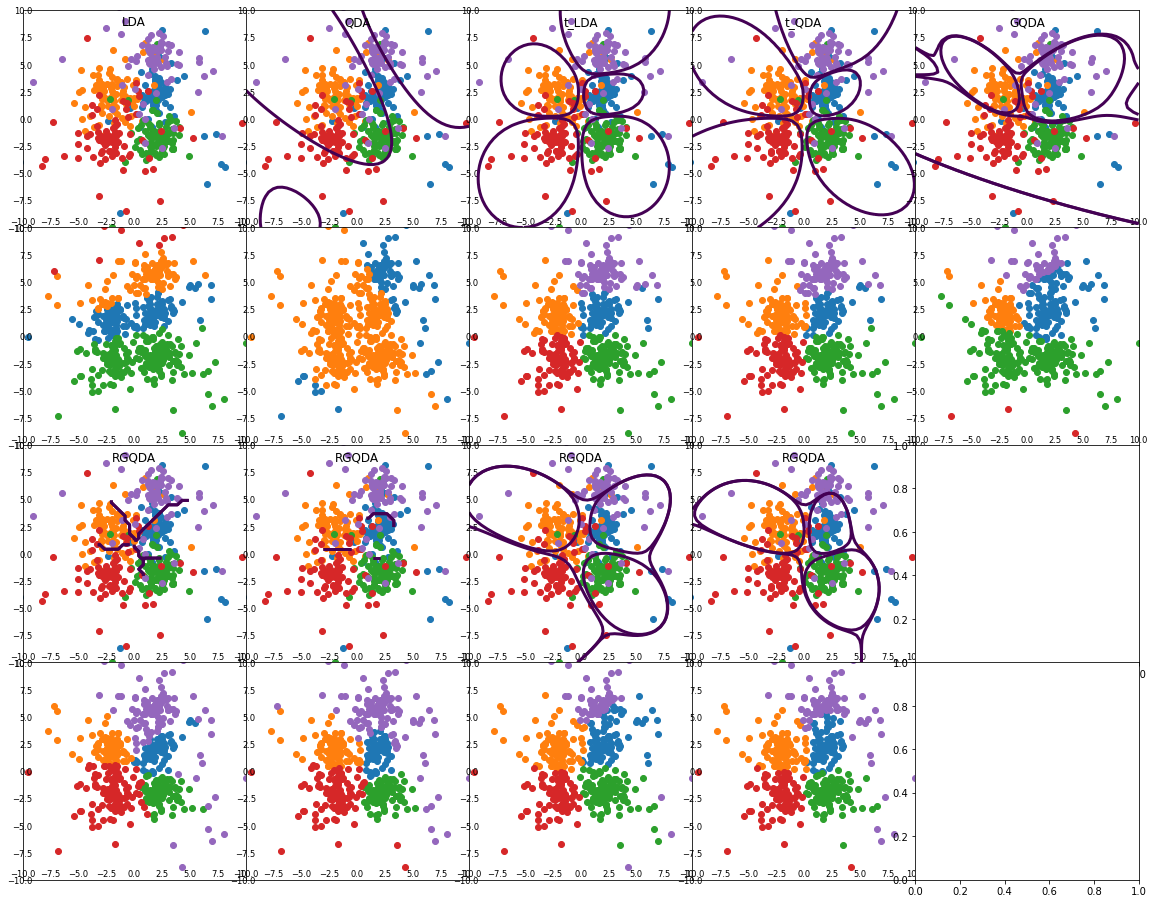

In [351]:
plot_models(X_2d, y_2d, X_test_2d, models_vis)

In [352]:
test = t_QDA(method='generalised')
test.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), test.predict(X_test_2d))

Accuracy 0.788 ARI 0.55757 AMI 0.5499


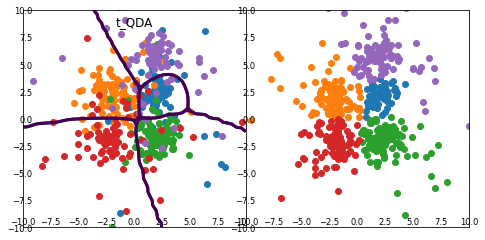

In [353]:
plot_models(X_2d, y_2d, X_test_2d, test)

## Statlog test

### Prepare Statlog data

In [30]:
read_statlog = pd.read_csv(r"data\statlog.csv")
statlog_labels = read_statlog.iloc[:, 0]
statlog_data = read_statlog.iloc[:, 1:]

In [31]:
# train test split
statlog_train, statlog_test, statlog_labels, statlog_test_labels = train_test_split(statlog_data, statlog_labels, test_size=0.33, random_state=42)
statlog_train = np.array(statlog_train); statlog_test = np.array(statlog_test); statlog_labels = np.array(statlog_labels); statlog_test_labels = np.array(statlog_test_labels); 

### Pure Statlog test

In [32]:
models_statlog_pure = run_all(statlog_train, statlog_labels, statlog_test, statlog_test_labels)

LDA
Accuracy 0.71053 ARI 0.17144 AMI 0.11268
QDA
Accuracy 0.69737 ARI 0.14257 AMI 0.11038
t-LDA
Accuracy 0.64912 ARI 0.08505 AMI 0.06629
t-QDA
Accuracy 0.74561 ARI 0.23714 AMI 0.16617
GQDA
optimal c is 0.1758430628550596
Accuracy 0.72368 ARI 0.19598 AMI 0.13574
RGQDA
optimal c is 0.09106056204551535
Accuracy 0.63596 ARI 0.0669 AMI 0.1037
RGQDA-S
optimal c is 0.0
Accuracy 0.60965 ARI 0.04331 AMI 0.0464
RQDA-M
Accuracy 0.72807 ARI 0.20217 AMI 0.1367
RQDA-S
Accuracy 0.62281 ARI 0.05631 AMI 0.04244


### Statlog with mislabelling test

In [33]:
statlog_labels_mislabelled = flip_bits(statlog_labels, 0.1)

In [34]:
models_statlog_mislabelling = run_all(statlog_train, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
Accuracy 0.68421 ARI 0.13079 AMI 0.08453
QDA
Accuracy 0.67105 ARI 0.10198 AMI 0.07371
t-LDA
Accuracy 0.61404 ARI 0.0476 AMI 0.04568
t-QDA
Accuracy 0.75 ARI 0.24623 AMI 0.17607
GQDA
optimal c is 0.03397003818538401
Accuracy 0.64035 ARI 0.0745 AMI 0.06916
RGQDA
optimal c is 0.0720609544695333
Accuracy 0.61842 ARI 0.04783 AMI 0.09393
RGQDA-S
optimal c is 0.31572786701431294
Accuracy 0.60526 ARI 0.04018 AMI 0.03355
RQDA-M
Accuracy 0.72368 ARI 0.19346 AMI 0.13078
RQDA-S
Accuracy 0.61842 ARI 0.05205 AMI 0.03858


### Statlog with contamination test

In [35]:
statlog_train_contaminated = contaminate_dataset(statlog_train, 0.1)

In [36]:
models_statlog_contaminated = run_all(statlog_train_contaminated, statlog_labels, statlog_test, statlog_test_labels)

LDA
Accuracy 0.7193 ARI 0.18146 AMI 0.13861
QDA
Accuracy 0.65351 ARI 0.0699 AMI 0.0988
t-LDA
Accuracy 0.64912 ARI 0.08395 AMI 0.09163
t-QDA
Accuracy 0.75 ARI 0.24646 AMI 0.17932
GQDA
optimal c is 0.03734033187007864
Accuracy 0.73246 ARI 0.20749 AMI 0.15089
RGQDA
optimal c is 0.054702889653776024
Accuracy 0.61842 ARI 0.04821 AMI 0.0893
RGQDA-S
optimal c is 0.9255487551632893
Accuracy 0.63596 ARI 0.06968 AMI 0.04617
RQDA-M
Accuracy 0.72368 ARI 0.19171 AMI 0.13485
RQDA-S
Accuracy 0.63596 ARI 0.06968 AMI 0.04617


### Statlog with contamination and mislabelling test

In [37]:
models_statlog_contaminated_mislabelling = run_all(statlog_train_contaminated, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
Accuracy 0.7193 ARI 0.18146 AMI 0.13861
QDA
Accuracy 0.65351 ARI 0.0699 AMI 0.0988
t-LDA
Accuracy 0.64912 ARI 0.08395 AMI 0.09163
t-QDA
Accuracy 0.75 ARI 0.24646 AMI 0.17932
GQDA
optimal c is 0.03734033187007864
Accuracy 0.73246 ARI 0.20749 AMI 0.15089
RGQDA
optimal c is 0.054702889653776024
Accuracy 0.61842 ARI 0.04821 AMI 0.0893
RGQDA-S
optimal c is 0.9255030648401202
Accuracy 0.63596 ARI 0.06968 AMI 0.04617
RQDA-M
Accuracy 0.72368 ARI 0.19171 AMI 0.13485
RQDA-S
Accuracy 0.63596 ARI 0.06968 AMI 0.04617


## NORB test

### Prepare NORB data

In [ ]:
from smallnorb import *

In [ ]:
NORB = SmallNORBDataset(dataset_root='data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

In [ ]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)
#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

In [ ]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

In [ ]:
norb_embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

norb_label = pd.Series(NORB_labels_sel)
norb_em = pd.DataFrame(norb_embedding, columns=['A','B']) 
norb_em['labels'] = norb_label.astype(str)
norb_gg = ggplot(aes(x='A', y='B', color='labels'), data=norb_em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)
norb_gg

### Pure NORB test

In [ ]:
models_NORB_pure = run_all(NORB_pca, NORB_labels_sel, #?? create NORB test data

In [ ]:
for c in np.linspace(0.01,1,100):
    test_gqda.c = c
    accuracies += [acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))]

In [ ]:
test_gqda.c = 1
test_gqda.fudge = 0
acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))

In [ ]:
plt.scatter(X[:,0],X[:,1])
plot_contours(X, test_gqda.predict_proba, plt.gca())